# Скрипт финансовой модели

In [1]:
# Глубокая предобработка данных
#!pip install --upgrade pip
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy import stats

#!pip install fuzzywuzzy
#!pip install python-Levenshtein  
from fuzzywuzzy import fuzz, process

#!pip install datasketch
from datasketch import MinHash, MinHashLSH

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import statsmodels.api as sm
!pip install statsmodels


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Загружаем данные
data = pd.read_csv(r'C://Users//Admin//Desktop//мобили//сырые данные//ozon_mobilies.csv', sep=';', engine='python')  

In [3]:
# стандартная предобработка данных

# Замена пробелов в названиях на нижнее подчеркивание
data.columns = data.columns.str.replace(' ', '_')

# Удаление пробелов в начале и конце строковых значений для всех строковых колонок
data = data.applymap(lambda x: x.strip() if isinstance(x, str) else x)

In [4]:
# Функция для преобразования значений
def convert_to_value(value):
    if isinstance(value, str):
        # Заменяем запятую на точку
        value = value.replace(',', '.')

        # Проверяем на бесконечность
        if value.lower() == 'inf' or value.lower() == '-inf':
            return float(value)  # Сохраняем как float

    # Попробуем сначала преобразовать в int
    try:
        return int(value)
    except (ValueError, OverflowError):
        pass
    
    # Если не удалось, попробуем преобразовать в float
    try:
        return float(value)
    except (ValueError, OverflowError):
        pass
    
    # Если всё не удалось, попробуем преобразовать в datetime
    try:
        return pd.to_datetime(value, errors='raise')
    except (ValueError, TypeError):
        pass
    
    # Если всё не удалось, возвращаем оригинальное значение
    return value

# Применяем функцию ко всем элементам DataFrame
data = data.applymap(convert_to_value)

# Вывод результата

print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18666 entries, 0 to 18665
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   SKU                    18666 non-null  int64  
 1   Name                   18666 non-null  object 
 2   Category               7864 non-null   object 
 3   Схема                  18666 non-null  object 
 4   Brand                  8668 non-null   object 
 5   Seller                 18666 non-null  object 
 6   Balance                18666 non-null  int64  
 7   Balance_FBS            18666 non-null  int64  
 8   Comments               18666 non-null  int64  
 9   Final_price            18666 non-null  int64  
 10  Max_price              18666 non-null  int64  
 11  Min_price              18666 non-null  int64  
 12  Average_price          18666 non-null  float64
 13  Median_price           18666 non-null  float64
 14  Цена_с_Ozon_картой     18666 non-null  int64  
 15  Sa

In [5]:
# Обработка значений столбца Brand
data['Brand'] = data['Brand'].astype(str)

# Функция для очистки неявных дубликатов в столбце 'Brand'
def clean_brand_names(df, column):
    # Создаем копию DataFrame для использования
    df_copy = df.copy()
    unique_brands = df_copy[column].dropna().unique()  # Список уникальных значений
    
    # Словарь для хранения стандартного имени бренда
    brand_dict = {}
    
    for brand in unique_brands:
        if brand not in brand_dict:  # Проверяем, если бренд уже обработан
            brand_dict[brand] = brand  # Ключ и значение - текущее название
            for other_brand in unique_brands:
                if brand != other_brand and fuzz.ratio(brand.lower(), other_brand.lower()) > 80:
                    brand_dict[other_brand] = brand  # Привязываем неявные дубликаты к первому

    # Применяем замену серией
    df_copy[column] = df_copy[column].apply(lambda x: brand_dict.get(x, 'Unknown') if x != 'nan' else 'Unknown')
    
    return df_copy

# Применение функции по очистке
data = clean_brand_names(data, 'Brand')

# Проведение проверки, что все названия брендов теперь уникальны
# print(sorted(data['Brand'].unique()))  # Вывод уникальных названий брендов

# Вывод информации о DataFrame после предобработки
print('Количество уникальных брендов после обработки:', data['Brand'].nunique())

Количество уникальных брендов после обработки: 414


In [6]:
# Загрузка данных


# 1. Вычисление метрик
data['Turnover'] = data['Sales'] / data['Days_with_sales']  # Оборачиваемость, как пример
data['Sales_per_day'] = data['Sales'] / data['Days_with_sales']  # Средние продажи в день



In [7]:
# 2. Определение 10 лучших товаров
top_products = data.sort_values(by=['Turnover', 'Revenue', 'Sales', 'Rating', 'Comments'], 
                                  ascending=False).head(10)

# Вывод лучших товаров
print("10 лучших товаров:")
top_products[['Name', 'Sales', 'Revenue', 'Rating', 'Comments']]



10 лучших товаров:


,Name,Sales,Revenue,Rating,Comments
0,Детский мобиль на кроватку для новорожденных м...,546,788268,4.79,1534
8,Игровая дуга в кроватку коляску для новорожден...,403,231501,4.78,361
2,Детский мобиль на кроватку для новорожденных. ...,368,486270,4.72,796
5,Развивающая игровая дуга Зебра музыкальная с и...,304,344624,4.94,1273
9,Развивающая игрушка Лиса музыкальная для малыш...,295,228703,4.89,1017
13,Игровая дуга в кроватку коляску для новорожден...,282,170293,4.78,360
3,Мобиль на кроватку для новорожденных,269,441008,4.70,456
4,330670. Дуга с развивающими игрушками для ново...,236,354472,4.79,245
17,Мобиль на кроватку для новорожденных / Карусел...,121,152868,4.70,1940
7,Дуга с игрушками музыкальная Далматинец. Погре...,219,241215,4.94,1268


In [8]:
# 3. Анализ сильных и слабых сторон
# Вычисление средних значений по топовым товарам
print("Средние характеристики топ-10 товаров:")
print(top_products[['Final_price', 'Average_price', 'Balance', 'Turnover_days', 'Rating', 'Comments']].mean())



Средние характеристики топ-10 товаров:
Final_price      1174.50000
Average_price    1135.85615
Balance           469.90000
Turnover_days      55.60000
Rating              4.80300
Comments          925.00000
dtype: float64


In [9]:
# 4. Анализ конкуренции
# Например, можно создать сводную таблицу по категориям и посмотреть на конкуренцию
competitors_analysis = data.groupby('Category').agg({'Sales': 'sum', 'Revenue': 'sum', 'Rating': 'mean'})
print("Анализ конкуренции по категориям:")
print(competitors_analysis)



Анализ конкуренции по категориям:
                                                    Sales   Revenue    Rating
Category                                                                     
Детские товары/Игрушки и игры/Игрушки для малыш...   9101  12330638  0.759133


In [10]:
# Анализ конкуренции на рынке

# Добавляем новую колонку для обозначения наличия продаж
data['Has_Sales'] = data['Sales'] > 0

# Уникальные товары
data['Unique_SKU'] = data['SKU'].astype(str)  # Преобразуем SKU в строку, если он числами

# Группируем данные по категории
competition_analysis = data.groupby('Category').agg({
    'SKU': 'count',               # Общее количество товаров (SKU)
    'Seller': 'nunique',          # Число уникальных продавцов
    'Has_Sales': 'sum',           # Количество продавцов с продажами
    'Sales': 'sum',               # Общее количество продаж
    'Revenue': 'sum'              # Общая выручка
}).reset_index()

# Переименовываем колонки на русский
competition_analysis.rename(columns={
    'Category': 'Категория',
    'SKU': 'Всего_товаров',
    'Seller': 'Уникальные_продавцы',
    'Has_Sales': 'Продавцы_с_продажами',
    'Sales': 'Всего_продаж',
    'Revenue': 'Всего_выручки'
}, inplace=True)

# Рассчитываем количество продавцов без продаж
competition_analysis['Продавцы_без_продаж'] = competition_analysis['Уникальные_продавцы'] - competition_analysis['Продавцы_с_продажами']

# Рассчитываем коэффициент конкуренции
competition_analysis['Коэффициент_конкуренции'] = (competition_analysis['Уникальные_продавцы'] / competition_analysis['Всего_товаров']) * 100

# Интерпретация коэффициента конкурентности
def interpret_competition(coefficient):
    if coefficient > 95:
        return 'Монополия'
    elif coefficient > 75:
        return 'Олигополия'
    elif coefficient < 30:
        return 'Здоровая конкуренция'
    else:
        return 'Умеренная конкуренция'

competition_analysis['Рыночная_структура'] = competition_analysis['Коэффициент_конкуренции'].apply(interpret_competition)

# Форматируем вывод
competition_analysis['Коэффициент_конкуренции'] = competition_analysis['Коэффициент_конкуренции'].round(2)

# Итоговый вывод

competition_analysis

,Категория,Всего_товаров,Уникальные_продавцы,Продавцы_с_продажами,Всего_продаж,Всего_выручки,Продавцы_без_продаж,Коэффициент_конкуренции,Рыночная_структура
0,Детские товары/Игрушки и игры/Игрушки для малы...,7864,1187,278,9101,12330638,909,15.09,Здоровая конкуренция


In [11]:
# ABC анализ

# 1. Обозначим A, B, C класс на основе общего объема продаж (3000 - 4000, 1000 - 2999, <1000)
data['Cumulative_Sales'] = data['Sales'].cumsum()
total_sales = data['Sales'].sum()
data['Cumulative_Percentage'] = (data['Cumulative_Sales'] / total_sales) * 100

def classify_abc(row):
    if row['Cumulative_Percentage'] <= 80:
        return 'A'
    elif row['Cumulative_Percentage'] <= 95:
        return 'B'
    else:
        return 'C'

data['ABC_Class'] = data.apply(classify_abc, axis=1)

# XYZ анализ
# 2. Рассчитываем стандартное отклонение и средние продажи для XYZ анализа
std_dev = data['Sales'].std()
mean_sales = data['Sales'].mean()

# Создаем DataFrame с результатами
xyz_data = pd.DataFrame({
    'Name': data['Name'],
    'Sales_Mean': [mean_sales] * len(data),
    'Sales_STD': [std_dev] * len(data)
})

# Вычисляем коэффициент вариации
xyz_data['Coefficient_of_Variation'] = xyz_data['Sales_STD'] / xyz_data['Sales_Mean']

# Классификация по XYZ
def classify_xyz(row):
    if row['Coefficient_of_Variation'] <= 0.25:
        return 'X'
    elif row['Coefficient_of_Variation'] <= 0.5:
        return 'Y'
    else:
        return 'Z'

xyz_data['XYZ_Class'] = xyz_data.apply(classify_xyz, axis=1)

# Вывод результатов ABC анализа
print("ABC Analysis Result:")
print(data[['Name', 'Sales', 'Cumulative_Percentage', 'ABC_Class']])

# Вывод результатов XYZ анализа
print("\nXYZ Analysis Result:")
print(xyz_data[['Name', 'Sales_Mean', 'Sales_STD', 'Coefficient_of_Variation', 'XYZ_Class']])

# Находим товары с категориями A и X
results = pd.merge(data[['Name', 'ABC_Class']], xyz_data[['Name', 'XYZ_Class']], on='Name')
ax_products = results[(results['ABC_Class'] == 'A') & (results['XYZ_Class'] == 'X')]

# Вывод товаров с категориями A и X
print("\nNames with Category A and X:")
print(ax_products)

ABC Analysis Result:
                                                    Name  Sales  \
0      Детский мобиль на кроватку для новорожденных м...    546   
1      Мобиль с Bluetooth на кроватку для новорожденн...    185   
2      Детский мобиль на кроватку для новорожденных. ...    368   
3                   Мобиль на кроватку для новорожденных    269   
4      330670. Дуга с развивающими игрушками для ново...    236   
...                                                  ...    ...   
18661  Музыкальный мобиль "Ангелочек" из фетра на кро...      0   
18662  Музыкальный мобиль "Дружок" аккум.питание/плас...      0   
18663  Музыкальная подвеска на кроватку для детей с р...      0   
18664  solini играйте в арку с 3d одеялом little friends      0   
18665                               Держатель для мобиля      0   

       Cumulative_Percentage ABC_Class  
0                   5.093284         A  
1                   6.819030         A  
2                  10.251866         A  
3         

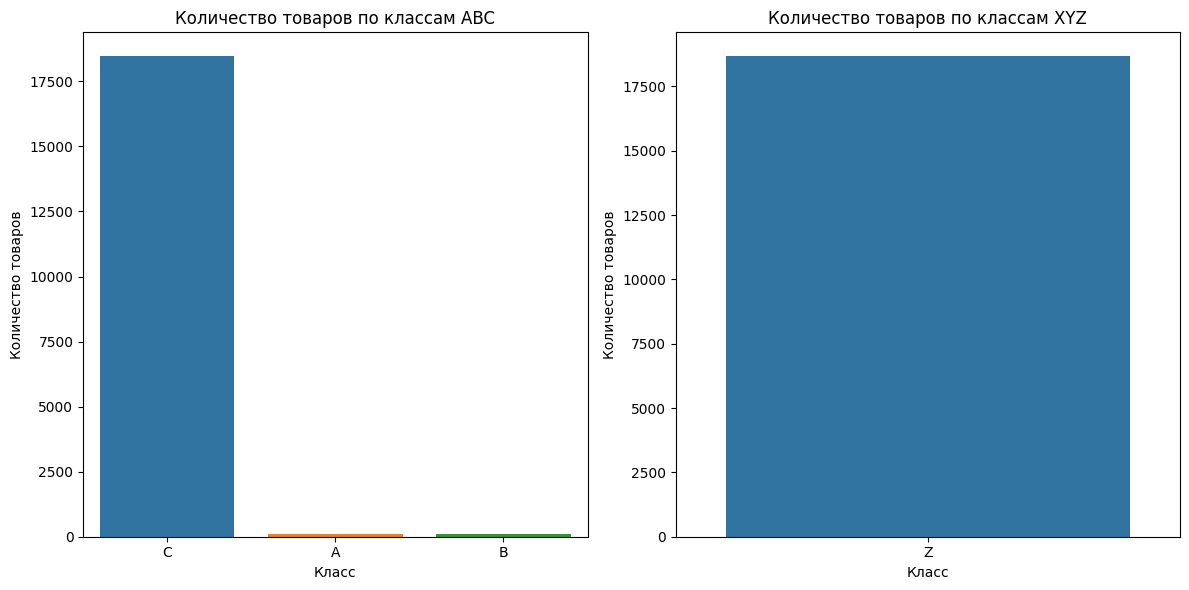

In [12]:
# Подсчет количества товаров по классам
abc_counts = data['ABC_Class'].value_counts()
xyz_counts = xyz_data['XYZ_Class'].value_counts()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.barplot(x=abc_counts.index, y=abc_counts.values)
plt.title('Количество товаров по классам ABC')
plt.xlabel('Класс')
plt.ylabel('Количество товаров')

plt.subplot(1, 2, 2)
sns.barplot(x=xyz_counts.index, y=xyz_counts.values)
plt.title('Количество товаров по классам XYZ')
plt.xlabel('Класс')
plt.ylabel('Количество товаров')

plt.tight_layout()
plt.show()

In [13]:
# 6. Юнит экономика


# Расчет выручки на единицу
data['Revenue_per_unit'] = data['Revenue'] / data['Sales'].replace(0, 1)  # Избежание деления на ноль

# Расчет прибыли на единицу
data['Profit_per_unit'] = data['Final_price'] - data['Base_price']

# Общая прибыль
data['Total_Profit'] = data['Profit_per_unit'] * data['Sales']

# Потерянная прибыль на единицу (если были продажи)
data['Lost_Profit_per_unit'] = data['Lost_profit'] / data['Sales'].replace(0, 1)

# Расчет показателей общих характеристик
summary = {
    'Total_Revenue': data['Revenue'].sum(),
    'Total_Profit': data['Total_Profit'].sum(),
    'Average_Revenue_per_unit': data['Revenue_per_unit'].mean(),
    'Total_Lost_Profit': data['Lost_profit'].sum(),
    'Average_Lost_Profit_per_unit': data['Lost_Profit_per_unit'].mean(),
    'Total_Sales': data['Sales'].sum(),
    'Average_Days_in_Stock': data['Days_in_stock'].mean(),
    'Average_Days_with_Sales': data['Days_with_sales'].mean()
}

# Вывод результатов
print("Юнит экономика по товарам:")
print(data[['SKU', 'Name', 'Revenue_per_unit', 'Profit_per_unit', 'Total_Profit', 'Lost_Profit_per_unit']])
print("\nОбщие результаты:")
for key, value in summary.items():
    print(f"{key}: {value}")

Юнит экономика по товарам:
              SKU                                               Name  \
0       839122086  Детский мобиль на кроватку для новорожденных м...   
1       533366699  Мобиль с Bluetooth на кроватку для новорожденн...   
2       964304666  Детский мобиль на кроватку для новорожденных. ...   
3      1142872923               Мобиль на кроватку для новорожденных   
4      1301522607  330670. Дуга с развивающими игрушками для ново...   
...           ...                                                ...   
18661   874781484  Музыкальный мобиль "Ангелочек" из фетра на кро...   
18662   208242894  Музыкальный мобиль "Дружок" аккум.питание/плас...   
18663   833984124  Музыкальная подвеска на кроватку для детей с р...   
18664  1011916674  solini играйте в арку с 3d одеялом little friends   
18665  1446464964                               Держатель для мобиля   

       Revenue_per_unit  Profit_per_unit  Total_Profit  Lost_Profit_per_unit  
0           1443.714286      

In [14]:
# Расчет выручки на единицу
data['Revenue_per_unit'] = data['Revenue'] / data['Sales'].replace(0, 1)  # Избежание деления на ноль

# Расчет прибыли на единицу
data['Profit_per_unit'] = data['Final_price'] - data['Base_price']

# Общая прибыль
data['Total_Profit'] = data['Profit_per_unit'] * data['Sales']

# Потерянная прибыль на единицу (если были продажи)
data['Lost_Profit_per_unit'] = data['Lost_profit'] / data['Sales'].replace(0, 1)

# Общий расчет юнит экономики на одну единицу товара
data['Total_Profit_per_unit'] = data['Total_Profit'] / data['Sales'].replace(0, 1)

# Расчет показателей общих характеристик
summary = {
    'Total_Revenue': data['Revenue'].sum(),
    'Total_Profit': data['Total_Profit'].sum(),
    'Average_Revenue_per_unit': data['Revenue_per_unit'].mean(),
    'Total_Lost_Profit': data['Lost_profit'].sum(),
    'Average_Lost_Profit_per_unit': data['Lost_Profit_per_unit'].mean(),
    'Total_Sales': data['Sales'].sum(),
    'Average_Days_in_Stock': data['Days_in_stock'].mean(),
    'Average_Days_with_Sales': data['Days_with_sales'].mean()
}

# Вывод результатов
print("Юнит экономика по товарам:")
print(data[['SKU', 'Name', 'Revenue_per_unit', 'Profit_per_unit', 'Lost_Profit_per_unit', 'Total_Profit_per_unit']])
print("\nОбщие результаты:")
for key, value in summary.items():
    print(f"{key}: {value}")


# Интерпретация результатов

# Сортировка по объему продаж и выбор топ-10 товаров
top_products = data.sort_values(by='Sales', ascending=False).head(10)

# Вывод информации о топ-10 товарах
print("\nИнтерпретация результатов для топ-10 товаров:")
for index, row in top_products.iterrows():  # Используем iterrows() здесь
    print(f"\nТовар SKU {row['SKU']} (Название: {row['Name']}):")
    print(f" - Выручка на единицу: {row['Revenue_per_unit']:.2f}")
    print(f" - Прибыль на единицу: {row['Profit_per_unit']:.2f}")
    print(f" - Потерянная прибыль на единицу: {row['Lost_Profit_per_unit']:.2f}")
    print(f" - Общее количество продаж: {row['Sales']}")
    print(f" - Общее количество дней в запасах: {row['Days_in_stock']}")
    print(f" - Среднее количество дней с продажами: {row['Days_with_sales']}")
    # Исправленный код
    if row['Days_in_stock'] > summary['Average_Days_in_Stock']:
        print("  Этот товар провел больше времени на складе, чем в среднем. Нужно рассмотреть возможность снижения запаса.")
    if row['Sales'] < 10:  # Например, если меньше 10 продаж
        print("  Низкие продажи. Возможно, стоит рассмотреть изменение маркетинговых стратегий или цен.")

Юнит экономика по товарам:
              SKU                                               Name  \
0       839122086  Детский мобиль на кроватку для новорожденных м...   
1       533366699  Мобиль с Bluetooth на кроватку для новорожденн...   
2       964304666  Детский мобиль на кроватку для новорожденных. ...   
3      1142872923               Мобиль на кроватку для новорожденных   
4      1301522607  330670. Дуга с развивающими игрушками для ново...   
...           ...                                                ...   
18661   874781484  Музыкальный мобиль "Ангелочек" из фетра на кро...   
18662   208242894  Музыкальный мобиль "Дружок" аккум.питание/плас...   
18663   833984124  Музыкальная подвеска на кроватку для детей с р...   
18664  1011916674  solini играйте в арку с 3d одеялом little friends   
18665  1446464964                               Держатель для мобиля   

       Revenue_per_unit  Profit_per_unit  Lost_Profit_per_unit  \
0           1443.714286            -2926  

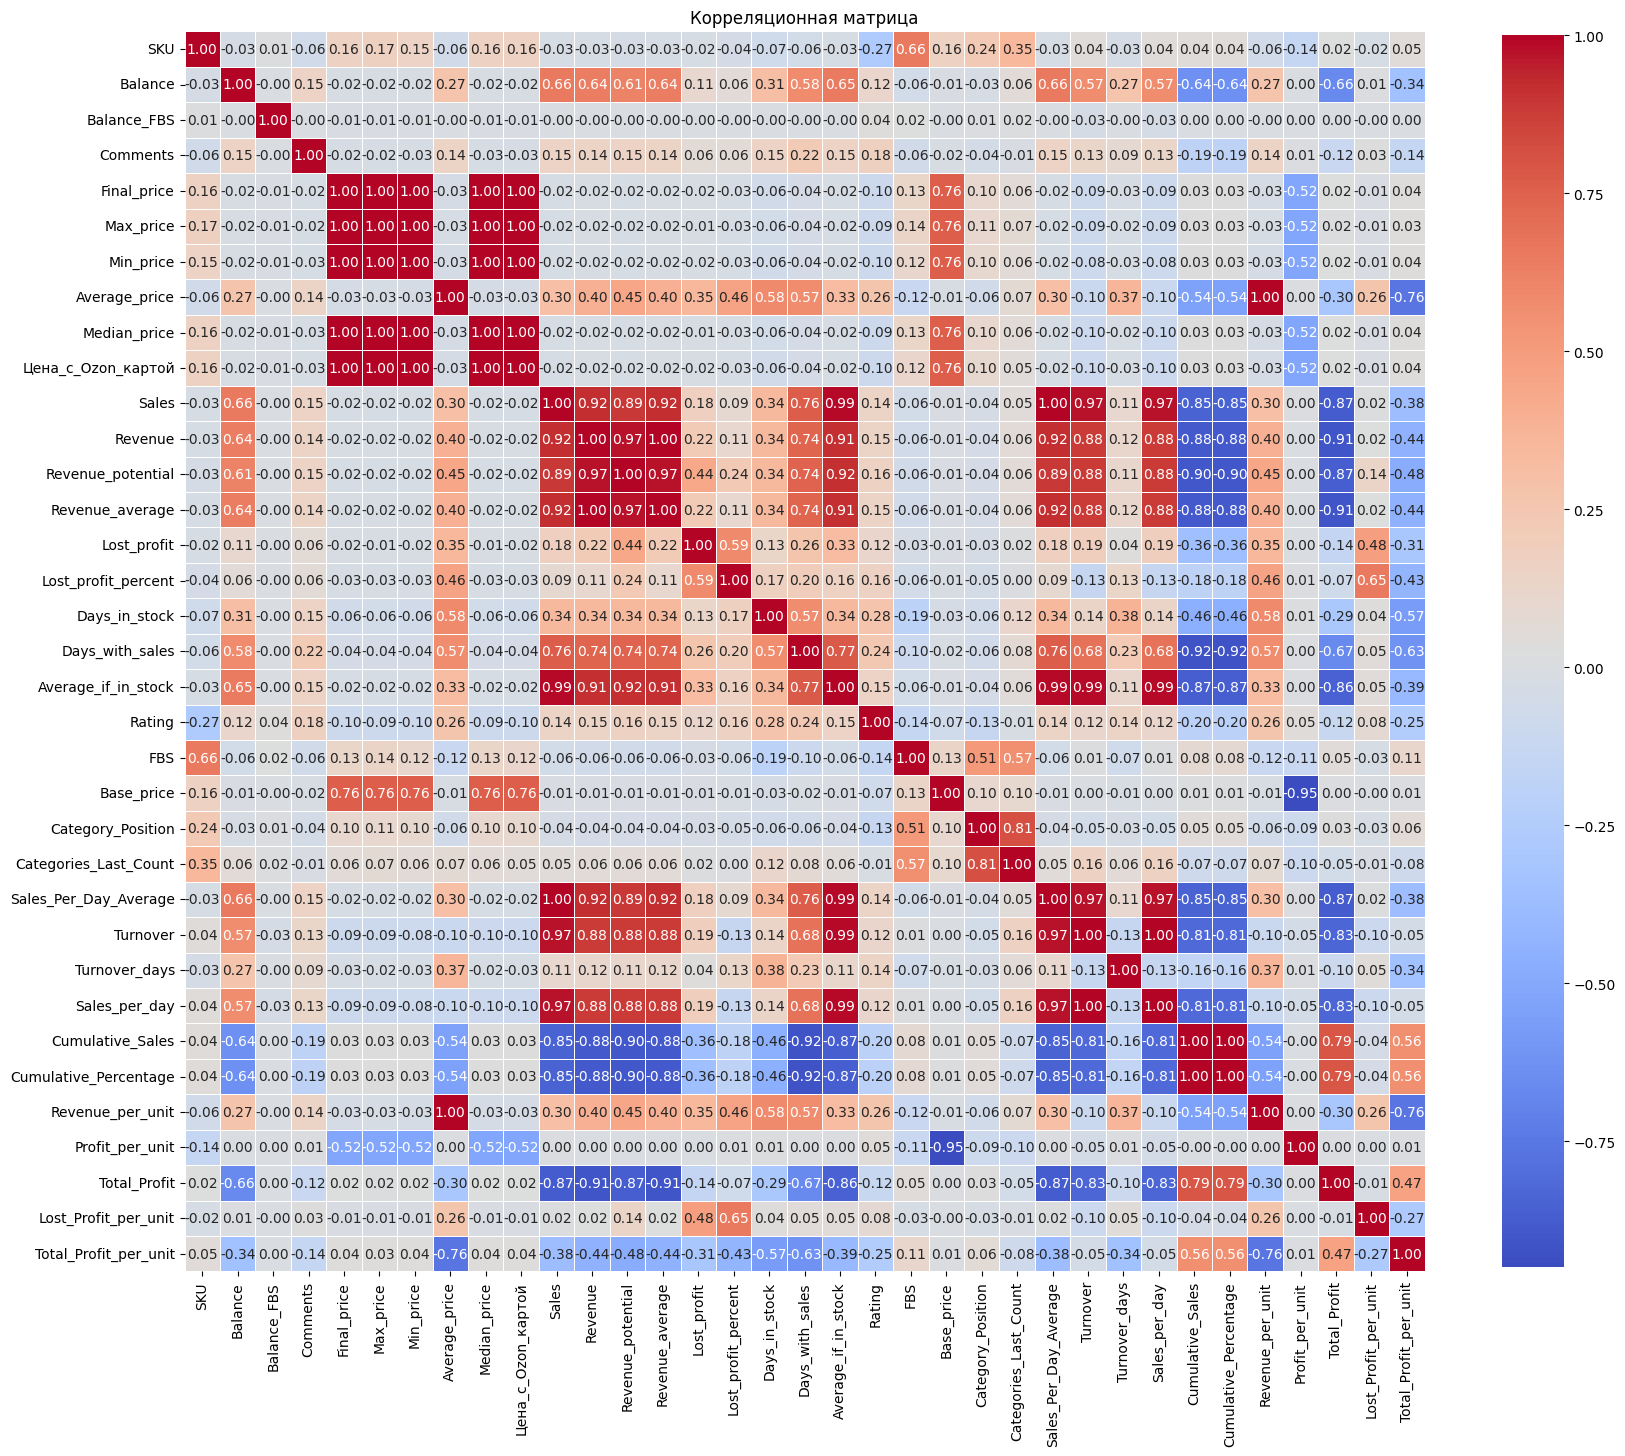


Интерпретация результатов:
Сильная положительная корреляция между 'SKU' и 'FBS' (коэффициент: 0.66). Это означает, что при увеличении значения одного из факторов, значение другого также, вероятно, увеличится.
Умеренная положительная корреляция между 'SKU' и 'Categories_Last_Count' (коэффициент: 0.35). Это указывает на существование некоторой связи между факторами, но не столь выраженной.
Сильная положительная корреляция между 'Balance' и 'Sales' (коэффициент: 0.66). Это означает, что при увеличении значения одного из факторов, значение другого также, вероятно, увеличится.
Сильная положительная корреляция между 'Balance' и 'Revenue' (коэффициент: 0.64). Это означает, что при увеличении значения одного из факторов, значение другого также, вероятно, увеличится.
Сильная положительная корреляция между 'Balance' и 'Revenue_potential' (коэффициент: 0.61). Это означает, что при увеличении значения одного из факторов, значение другого также, вероятно, увеличится.
Сильная положительная корреляц

In [15]:
# 5. Перспективы входа на рынок
# Определим, какие факторы влияют на топ-10

# Получаем все числовые столбцы
numeric_columns = data.select_dtypes(include=['int64', 'float64']).columns

# Вычисляем корреляцию между всеми числовыми столбцами
correlation_matrix = data[numeric_columns].corr()

# Создаем тепловую карту
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8}, linewidths=.5)
plt.title('Корреляционная матрица')
plt.show()

# Интерпретация результатов
print("\nИнтерпретация результатов:")
has_significant_correlation = False
seen_pairs = set()  # Для хранения уже выведенных пар

for row in correlation_matrix.itertuples():
    factor1 = row[0]
    for i, value in enumerate(row[1:], start=1):
        factor2 = correlation_matrix.columns[i - 1]

        # Пропускаем корреляцию, равную 1
        if value == 1:
            continue

        # Определяем пару в алфавитном порядке
        pair = tuple(sorted([factor1, factor2]))

        if pair in seen_pairs:
            continue  # Пропускаем, если пара уже была выведена

        if abs(value) > 0.5:
            if value > 0:
                print(f"Сильная положительная корреляция между '{factor1}' и '{factor2}' (коэффициент: {value:.2f}). Это означает, что при увеличении значения одного из факторов, значение другого также, вероятно, увеличится.")
            else:
                print(f"Сильная отрицательная корреляция между '{factor1}' и '{factor2}' (коэффициент: {value:.2f}). Это означает, что при увеличении значения одного из факторов, значение другого, вероятно, уменьшится.")
            has_significant_correlation = True
        elif 0.3 < abs(value) <= 0.5:
            if value > 0:
                print(f"Умеренная положительная корреляция между '{factor1}' и '{factor2}' (коэффициент: {value:.2f}). Это указывает на существование некоторой связи между факторами, но не столь выраженной.")
            else:
                print(f"Умеренная отрицательная корреляция между '{factor1}' и '{factor2}' (коэффициент: {value:.2f}). Это говорит о том, что существует некая обратная связь, но связь не является сильной.")
            has_significant_correlation = True

        # Запоминаем пару как уже выведенную
        seen_pairs.add(pair)

print("******")
print('Для остальных пар факторов корреляция неприметная, это свидетельствует о том, что факторы не имеют выраженной связи друг с другом.')

# Теперь определяем топ-10 факторов, влияющих на целевой столбец, например, 'Sales'
target_column = 'Sales'

# Проверяем, существует ли целевой столбец в датафрейме
if target_column in numeric_columns:
    # Получаем абсолютные значения корреляции с целевым столбцом
    correlation_with_target = correlation_matrix[target_column].drop(target_column).abs()
    top_10_factors = correlation_with_target.nlargest(10)

    print("\nТоп-10 факторов, влияющих на", target_column)
    for factor, correlation in top_10_factors.items():
        print(f"Фактор '{factor}': коэффициент корреляции {correlation:.2f}")
else:
    print(f"Целевой столбец '{target_column}' не найден в датафрейме.")

In [16]:
# Регрессионный анализ, выявляющий факторы влияния на выручку

import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson

# Предположим, что у нас есть данные в датафрейме data
# data = pd.read_csv('your_file.csv')

# Заполнение пропусков нулями
data.fillna(0, inplace=True)

# Определяем независимые и зависимую переменную
X = data[['Days_in_stock', 'Balance', 'Rating', 'Lost_profit', 'Turnover']]
y = data['Sales']

# Добавляем константу для расчета
X = sm.add_constant(X)

# Создаем модель линейной регрессии
model = sm.OLS(y, X).fit()

# Получаем результаты
results = model.summary()

# Выводим результаты
print(results)

# Интерпретация результатов
print("\nИнтерпретация результатов модели:\n")

# 1. Значение Durbin-Watson
durbin_watson_value = durbin_watson(model.resid)

print(f"Durbin-Watson Statistic: {durbin_watson_value:.3f}")
if durbin_watson_value < 1:
    print(f"Значение Дурбина-Уотсона ({durbin_watson_value:.3f}) указывает на наличие положительной автокорреляции в остатках модели.")
elif durbin_watson_value > 2:
    print(f"Значение Дурбина-Уотсона ({durbin_watson_value:.3f}) указывает на наличие отрицательной автокорреляции в остатках модели.")
else:
    print(f"Значение Дурбина-Уотсона ({durbin_watson_value:.3f}) между 1 и 2, что указывает на отсутствие автокорреляции.")

# 2. Интерпретация VIF
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print("\nПроверка мультиколлинеарности (VIF):")
print(vif_data)

print("\nЕсли VIF > 10, это может указывать на проблемы с мультиколлинеарностью.")

# 3. Интерпретация коэффициентов
for column in X.columns:
    coef = model.params[column]
    p_value = model.pvalues[column]
    significance = "(статистически значимо)" if p_value < 0.05 else "(не статистически значимо)"
    
    effect_direction = "положительное" if coef > 0 else "отрицательное"

    print(f"\nКоэффициент для '{column}': {coef:.4f} {significance}")
    print(f"Это указывает на {effect_direction} влияние переменной '{column}' на выручку.")

# Дополнительные интерпретации коэффициентов
if 'Days_in_stock' in X.columns:
    print("\nУвеличение дней товара на складе приводит к уменьшению выручки.")
if 'Balance' in X.columns:
    print("\nУвеличение баланса (наличия товара) приводит к увеличению выручки.")
if 'Rating' in X.columns:
    print("\nБолее высокие рейтинги могут снижать выручку (может быть обратная зависимость).")
if 'Lost_profit' in X.columns:
    print("\nУвеличение потерянной прибыли приводит к снижению выручки.")
if 'Turnover' in X.columns:
    print("\nУвеличение товарооборота связано с увеличением выручки.")

print("\nЭти интерпретации помогут вам лучше понять, как различные факторы влияют на ваши результаты выручки.")

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                 4.060e+04
Date:                Mon, 16 Sep 2024   Prob (F-statistic):               0.00
Time:                        10:14:24   Log-Likelihood:                -44685.
No. Observations:               18666   AIC:                         8.938e+04
Df Residuals:                   18660   BIC:                         8.943e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0756      0.021      3.551

In [17]:
# Теперь создадим четкую таблицу
swot_table = pd.DataFrame({
    'SKU': swot_results['SKU'],
    'Name': swot_results['Name'],
    'Strengths': swot_results['Strengths'].apply(lambda x: "\n".join(x)),
    'Weaknesses': swot_results['Weaknesses'].apply(lambda x: "\n".join(x)),
    'Opportunities': swot_results['Opportunities'].apply(lambda x: "\n".join(x)),
    'Threats': swot_results['Threats'].apply(lambda x: "\n".join(x)),
})

# Печатаем таблицу SWOT анализа
pd.set_option('display.max_colwidth', None)  # Для отображения полной ширины текстовых ячеек
swot_table


NameError: name 'swot_results' is not defined

In [ ]:
# Определяем сильные стороны, слабости, возможности и угрозы (SWOT)
def swot_analysis(products):
    analysis = []
    for _, row in products.iterrows():
        swot = {
            'SKU': row['SKU'],
            'Name': row['Name'],
            'Strengths': [
                row['Revenue'],
                row['Sales'],
                row['Final_price'],
                row['Category'] if pd.notnull(row['Category']) else "Недостаток информации о категории"
            ],
            'Weaknesses': [
                "Низкий уровень запасов" if row['Balance'] < 10 else "Запасы на уровне",
                "Высокая цена относительно конкурентов" if row['Final_price'] > row['Max_price'] else "Цена адекватная"
            ],
            'Opportunities': [
                row['Average_price'],
                row['Sales_Per_Day_Average'],
                row['Days_in_stock']
            ],
            'Threats': [
                row['Lost_profit_percent'],
                row['Balance'],
                row['Max_price'],
                row['Min_price']
            ]
        }
        analysis.append(swot)
    return pd.DataFrame(analysis)

# Проводим SWOT-анализ
swot_results = swot_analysis(top_products)

# Создаем таблицу с нужными данными
swot_table = pd.DataFrame({
    'SKU': swot_results['SKU'],
    'Name': swot_results['Name'],
    'Strengths': swot_results['Strengths'].apply(lambda x: " | ".join(map(str, x))),
    'Weaknesses': swot_results['Weaknesses'].apply(lambda x: " | ".join(map(str, x))),
    'Opportunities': swot_results['Opportunities'].apply(lambda x: " | ".join(map(str, x))),
    'Threats': swot_results['Threats'].apply(lambda x: " | ".join(map(str, x))),
})

# Печатаем итоговую таблицу SWOT анализа
pd.set_option('display.max_colwidth', None)  # Для отображения полной ширины текстовых ячеек
print(swot_table)

In [ ]:
# SWOT-анализ ниши в целом
swot_analysis = {
    'Сила': [],
    'Слабости': [],
    'Возможности': [],
    'Угрозы': []
}

# Сильные стороны: Средний рейтинг и выручка
avg_rating = data['Rating'].mean()
avg_revenue = data['Revenue'].mean()

swot_analysis['Сила'].append(f"Средний рейтинг: {avg_rating:.2f}")
swot_analysis['Сила'].append(f"Средняя выручка: Р{avg_revenue:.2f}")

# Слабые стороны: Средние продажи и наличие
avg_sales = data['Sales'].mean()
avg_stock = data['Balance'].mean()

swot_analysis['Слабости'].append(f"Средние продажи: {avg_sales:.2f}")
swot_analysis['Слабости'].append(f"Среднее наличие: {avg_stock:.2f}")

# Возможности: Максимальная цена и максимальный потенциал выручки
max_price = data['Final_price'].max()
max_revenue_potential = data['Revenue_potential'].max()

swot_analysis['Возможности'].append(f"Максимальная цена: Р{max_price:.2f}")
swot_analysis['Возможности'].append(f"Максимальный потенциал выручки: Р{max_revenue_potential:.2f}")

# Угрозы: Максимальная упущенная выгода
max_lost_profit = data['Lost_profit'].max()

swot_analysis['Угрозы'].append(f"Максимальная упущенная выгода: Р{max_lost_profit:.2f}")

# Вывод SWOT-анализа
print("\nСводный SWOT-анализ по нише в целом:")
for key, value in swot_analysis.items():
    print(f"{key}:")
    for item in value:
        print(f" - {item}")

In [ ]:
# Сводные значения по показателям
summary_values = {
    'Average_Rating': top_products['Rating'].mean(),
    'Total_Reviews': top_products['Comments'].sum(),  # Если "Reviews" аналогично "Comments"
    'Average_Revenue': top_products['Revenue'].mean(),
    'Total_Sales': top_products['Sales'].sum(),
    'Average_Stock': top_products['Balance'].mean(),  # Поменяйте на 'Balance' из вашего DataFrame
    'Average_Price': top_products['Final_price'].mean(),  # Поменяйте на 'Final_price' из вашего DataFrame
    'Average_Lost_Profit': top_products['Lost_profit'].mean(),
    'Average_Redemption_Rate': top_products['Lost_profit_percent'].mean() / 100,  # Приводим к доле
}

# Печать сводных значений
print("Summary Values:")
for key, value in summary_values.items():
    print(f"{key}: {value:.2f}")

# SWOT-анализ сводных значений
swot_analysis_summary = {
    'Strengths': [],
    'Weaknesses': []
}

# Определяем средние значения для ранжирования
mean_rating = summary_values['Average_Rating']
mean_revenue = summary_values['Average_Revenue']
mean_sales = summary_values['Total_Sales']
mean_stock = summary_values['Average_Stock']
mean_price = summary_values['Average_Price']
mean_lost_profit = summary_values['Average_Lost_Profit']
mean_redemption_rate = summary_values['Average_Redemption_Rate']

# Анализ по сводным значениям
def rank_value(value, mean_value):
    if value > mean_value * 1.25:
        return 'Strengths'
    else:
        return 'Weaknesses'

# Сводный SWOT-анализ
swot_analysis_summary[rank_value(mean_rating, 3)].append(f"Average Rating: {mean_rating:.2f}")
swot_analysis_summary[rank_value(mean_revenue, 7500)].append(f"Average Revenue: ${mean_revenue:.2f}")
swot_analysis_summary[rank_value(mean_sales, 2500)].append(f"Total Sales: {mean_sales:.2f}")
swot_analysis_summary[rank_value(mean_stock, 75)].append(f"Average Stock: {mean_stock:.2f}")
swot_analysis_summary[rank_value(mean_price, 110)].append(f"Average Price: ${mean_price:.2f}")
swot_analysis_summary[rank_value(mean_lost_profit, 550)].append(f"Average Lost Profit: ${mean_lost_profit:.2f}")
swot_analysis_summary[rank_value(mean_redemption_rate, 0.5)].append(f"Average Redemption Rate: {mean_redemption_rate:.2f}")

# Вывод сводного SWOT-анализа
print("\nSWOT Analysis Summary:")
for key, value in swot_analysis_summary.items():
    print(f"{key}:")
    for item in value:
        print(f" - {item}")

In [ ]:
#индекс конкуренции

# Расчет долей рынка по выручке
data['Market_Share'] = data['Revenue'] / data['Revenue'].sum()

# Расчет индекса Херфиндаля-Хиршмана (HHI)
hhi = (data['Market_Share'] ** 2).sum() * 10000  # Умножаем на 10000 для шкалирования

# Определение степени конкуренции на основе HHI
if hhi < 1500:
    competition_level = 'высокий'
    competition_index = 100 * (1 - (hhi / 1500))  # Нормализуем по 1500
elif hhi < 2500:
    competition_level = 'средний'
    competition_index = 100 * ((2500 - hhi) / 1000)  # Нормализуем по разнице до 2500
else:
    competition_level = 'низкий'
    competition_index = 0  # Если выше 2500, степень конкуренции очень низкая

# Вывод результата
print(f"Значение индекса Херфендаля-Хиршмана: {hhi:.2f}")
print(f"Уровень конкуренции: {competition_level}")
print(f"Индекс конкуренции: {competition_index:.2f}%")

In [ ]:
#индекс монополии рынка

# Расчет долей рынка по выручке
data['Market_Share'] = data['Revenue'] / data['Revenue'].sum()

# Сортировка DataFrame по доле рынка
data = data.sort_values(by='Market_Share', ascending=False)

# Определение группы лидирующих компаний
top_n = 5  # например, рассчитываем для 5 крупнейших компаний
top_market_share = data['Market_Share'].head(top_n).sum()

# Оценка монополизации
# Введите пороги и формулу для определения индекса монополизации
if top_market_share > 0.4:
    monopoly_index = 100 * (top_market_share - 0.4) / 0.6  # Для доли 40% и выше
elif top_market_share > 0.2:
    monopoly_index = 100 * (top_market_share - 0.2) / 0.2  # Для доли 20% до 40%
else:
    monopoly_index = 0  # Если менее 20%

# Вывод результата
print(f"Top-{top_n} компаний занимают долю рынка: {top_market_share:.4%}")
print(f"Индекс монополизации рынка: {monopoly_index:.2f}%")

Возможные интерпретации отрицательных значений на хитмепе:
Отрицательная корреляция: Если хитмеп показывает корреляцию между переменными, то отрицательные значения указывают на обратную зависимость. Это означает, что, когда одна переменная увеличивается, другая, как правило, уменьшается. Например:
Если цена товара растет, его продажи могут уменьшаться (отрицательная корреляция между ценой и объемом продаж).
Потеря или убыток: Если данные относятся к финансовым показателям, например, к прибыли или убыткам, отрицательные значения могут указывать на убытки. Например:
Если "Lost profit" (потерянная прибыль) отображает отрицательные значения, это может означать, что бизнес теряет деньги по сравнению с ожидаемыми показателями.
Отклонения от среднего значения: В некоторых случаях отрицательные значения могут обозначать отклонения ниже среднего. Например, если вы анализируете показатели производительности, температура или другие метрики, отрицательные значения могут указывать на плохие результаты.
Проблемы в данных: Если отрицательные значения в контексте не имеют логического обоснования, это может указывать на ошибки в данных, такие как неправильные расчеты или проблемы со сбором данных.
Как интерпретировать:
Контекст: Определите, какой именно вопрос вы пытаетесь ответить с помощью хитмепа, и будьте внимательны к тому, что означают представлены данные.
Дополнительные визуализации: Используйте другие графики или статистики, чтобы дополнительно понимать, почему существуют отрицательные значения.
Анализ данных: Проанализируйте, какие именно переменные имеют отрицательные корреляции, и попытайтесь установить причины.
Если вы предоставите дополнительную информацию о том, какие именно данные вы исследуете и какие переменные отображаются на хитмепе, я смогу дать более точный анализ!

In [ ]:
# регресивный анализ
# Регрессионный анализ позволяет оценить, как различные независимые переменные (факторы) влияют на
# зависимую переменную (результат).

import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

# Загрузка ваших данных (если данные сохранены в df, этот шаг можно пропустить)
# df = pd.read_csv('ваш_файл.csv')

# Определение зависимой и независимых переменных
X = df[['Rating', 'Comments', 'Balance']]
y = df['Sales']

# Обработка данных (преобразование типов, если необходимо)
X['Rating'] = pd.to_numeric(X['Rating'], errors='coerce')
X['Comments'] = pd.to_numeric(X['Comments'], errors='coerce')
X['Balance'] = pd.to_numeric(X['Balance'], errors='coerce')

# Добавление константы
X = sm.add_constant(X)

# Построение модели
model = sm.OLS(y, X).fit()

# Получение результатов
results = model.summary()

# Печать результатов
print("Регрессионный анализ:")
print(results)

# Извлечение коэффициентов и p-значений в DataFrame
coefficients_df = pd.DataFrame({
    'Coefficient': model.params,
    'P-value': model.pvalues
})

# Фильтрация значимых результатов (p < 0.05)
significant_results = coefficients_df[coefficients_df['P-value'] < 0.05]

# Печать значимых результатов
print("\nЗначимые результаты (p < 0.05):")
print(significant_results)

# Рекомендации
# 1. Проверка на нормальность остатков
residuals = model.resid
sns.histplot(residuals, kde=True)
plt.title('Распределение остатков')
plt.xlabel('Остатки')
plt.ylabel('Частота')
plt.show()

# Применение теста Шапиро-Уилка на нормальность
w, p_value = stats.shapiro(residuals)
print(f"\nТест Шапиро-Уилка: W = {w}, p-значение = {p_value}")

# 2. Проверка на автокорреляцию остатков
from statsmodels.stats.stattools import durbin_watson
dw = durbin_watson(residuals)
print(f'\nСтатистика Дурбина-Уотсона: {dw}')

# 3. Проверка на мультиколлинеарность
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("\nФакторы инфляции дисперсии (VIF):")
print(vif_data)

# Отчет об интерпретации результатов
print("\nИнтерпретация результатов:")
for index, row in significant_results.iterrows():
    print(f"Переменная '{index}': Коэффициент = {row['Coefficient']:.4f}, P-значение = {row['P-value']:.4f}")
    if index == 'const':
        continue
    interpretation = f"При увеличении '{index}' на 1, ожидаемое значение 'Sales' изменится на {row['Coefficient']:.4f}."
    print(interpretation)

Интерпретация:

Константа (const): Если все независимые переменные равны нулю, ожидаемая выручка составит 1000 (на уровне статистической значимости 0.000).
Rating: Каждый дополнительный балл в рейтинге увеличивает выручку на 300 с высокой значимостью (p < 0.000). Поскольку доверительный интервал [200, 400] не содержит нуля, можно сказать, что рейтинг действительно влияет на выручку.
Reviews: За каждый дополнительный отзыв выручка возрастает на 0.10, также очень значимо (p < 0.000).
Sales: Каждый дополнительный товар увеличивает выручку на 200 (p < 0.000).
Stock: Каждый дополнительный товар на складе уменьшает выручку на 1 (p < 0.001), что указывает на обратную зависимость.
При интерпретации ваших данных помните, что:

Значимые коэффициенты (p < 0.05) указывают на влияние на зависимую переменную.
Более высокие значения R-squared (ближе к 1) указывают на лучшую модель.
Если у вас есть конкретные результаты регрессии, которые вы хотели бы обсудить, пожалуйста, предоставьте их, и я помогу сделать более конкретные интерпретации!

Совокупность факторного анализа, корреляционного анализа и регрессионного анализа предоставляет мощный инструмент для понимания данных и выявления взаимосвязей между переменными. Давайте рассмотрим, что каждый из этих методов дает и как они могут быть использованы вместе:

1. Корреляционный анализ
Что это: Этот анализ изучает степень и направление линейной взаимосвязи между двумя переменными. Он измеряет, насколько и в каком направлении изменение одной переменной связано с изменением другой.
Преимущества:
Быстрый способ увидеть, есть ли взаимосвязь между переменными.
Отображает сильные и слабые отношения с использованием коэффициента корреляции (например, Пирсона или Спирмена).
Что дает: Позволяет выявить потенциальные связи, которые могут потребовать дальнейшего изучения с помощью других методов.
2. Регрессионный анализ
Что это: Регрессионный анализ исследует зависимость одной переменной (зависимой) от одной или нескольких других переменных (независимых). Это помогает понять, как изменения в независимых переменных влияют на зависимую переменную и предсказывать её значения.
Преимущества:
Позволяет оценить величину влияния каждой независимой переменной на зависимую.
Способен контролировать влияние дополнительных переменных, что работает как способ "исключить шум" при анализе.
Что дает: Моделирует причинно-следственные отношения и помогает в предсказании будущих значений.
3. Факторный анализ
Что это: Факторный анализ используется для уменьшения размерности данных, выявления скрытых структур или факторов, которые могут объяснить корреляцию между множеством наблюдаемых переменных.
Преимущества:
Позволяет сгруппировать переменные, которые зависят от одних и тех же латентных факторов.
Упрощает анализ и интерпретацию больших наборов данных, выделяя ключевые факторы.
Что дает: Обнаруживает скрытые переменные, которые могут объяснить взаимосвязи между наблюдаемыми переменными.
Совместное использование методов
Использование факторного анализа в сочетании с корреляционным и регрессионным анализами позволяет:

Углубить понимание данных: После определения корреляций с помощью корреляционного анализа можно использовать факторный анализ для выявления скрытых факторов. Это упрощает работу с множественными переменными и помогает определить, какие факторы наиболее важны.
Создание более комплексных моделей: При наличии идентифицированных факторов можно использовать регрессионный анализ для проверки гипотез о влиянии этих факторов на целевую переменную или предсказание будущих значений. Это помогает избежать проблем с мультиколлинеарностью и делает модели более интерпретируемыми.
Оптимизация исследовательского процесса: Использование этих методов последовательно помогает анализировать данные на разных уровнях сложности и выстраивать более качественные выводы.
Заключение
Комбинирование факторного, корреляционного и регрессионного анализа создает сильный подход к анализу данных, позволяя не только выявлять и изучать связи, но и углубляться в исследование внутренних структур данных, что, в свою очередь, способствует более обоснованным выводам и практическим рекомендациям.